In [1]:
import numpy  as np
import pandas as pd
import pylab as pl
import os, psutil # used to monitor memory usage
from   glob import glob
from   astropy.table import Table
from   astropy.io import fits
import corner

from   tqdm import tqdm

pl.style.use('/pscratch/sd/j/jfsuarez/plots.mplstyle')

In [2]:
import torch
from   torch              import nn
from   torch              import FloatTensor
from   torch.utils.data   import Dataset
from   torch.utils.data   import DataLoader
from   torch.nn           import functional as F
from   torchvision        import transforms, models
#from   torchvision.models import vit_l_16, ViT_L_16_Weights
#from   torchvision.models import vit_l_32, ViT_L_32_Weights
from   torchvision.models import swin_b, Swin_B_Weights
from   torchvision.models import swin_s, Swin_S_Weights
from   torchvision.models import swin_t, Swin_T_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet152, ResNet152_Weights

from   sklearn.metrics    import r2_score
from   sklearn.metrics    import mean_squared_error

In [3]:
from src.utils import mw_transmission
from src.utils import mag
from src.utils import metrics

In [4]:
class ReadDataset(Dataset):
    def __init__(self, data_paths, data):
        self.data_files = data_paths 
        self.data = data
        self.data_transforms = transforms.Compose([
            # transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __getitem__(self, index):
        TID = int(self.data_files[index].split('/')[-1].split('_')[1])
        #print(TID)
        #print(self.data_files[index])
        x = fits.open(self.data_files[index])
        #print(x)
        x = np.dstack([x[1].data, x[2].data, x[3].data])
        #print(x, type(x))
        x = self.data_transforms(x)
        #print(x)
        
        y = np.array(self.data['Z'][self.data['TARGETID']==TID], dtype=float)[0]
        y = torch.tensor(y).float()
        #print(x,y)
        return x, y
    
    def __len__(self):
        return len(self.data_files)

In [5]:
class GalaxyNet(torch.nn.Module):
    def __init__(self, pretrained=True, modelname='swins'):
        super().__init__()
        #print('hiii', model)
        if modelname=='vitl16':
            model = vit_l_16(weights=ViT_L_16_Weights.DEFAULT)
        elif modelname=='vitl32':
            model = vit_l_32(weights=ViT_L_32_Weights.DEFAULT)
        elif modelname=='swinb':
            model = swin_b(weights=Swin_B_Weights.DEFAULT)
        elif modelname=='swins':
            model = swin_s(weights=Swin_S_Weights.DEFAULT)
        elif modelname=='swint':
            model = swin_t(weights=Swin_T_Weights.DEFAULT)
        elif modelname=='resnet18':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
        elif modelname=='resnet50':
            model = resnet50(weights=ResNet50_Weights.DEFAULT)
        elif modelname=='resnet152':
            model = resnet152(weights=ResNet152_Weights.DEFAULT)

        else:
            print('Other model doesnt exist')
        
        count = 0
        #print(model)
        for child in model.children():  
            count += 1
            if count < 7:    
                for param in child.parameters():
                    param.requires_grad = False

        # for param in model.parameters():
        #     param.requires_grad = False        
        
        model.load_state_dict(model.state_dict())     
        
        self.features = torch.nn.ModuleList(model.children())[:-1]
        self.features = torch.nn.Sequential(*self.features)
        
        if 'swin' in modelname:
            self.fc1 = torch.nn.Linear(model.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'vit' in modelname:
            self.fc1 = torch.nn.Linear(model.heads.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'resnet' in modelname:
            self.fc1 = torch.nn.Linear(model.fc.in_features, 512)
            self.fc2 = torch.nn.Linear(512, 256)

        self.fc3 = torch.nn.Linear(256, 1)        
        
    def forward(self, x):
        #-Call Features
        x = self.features(x)
        
        #-Flatten
        x = x.view(x.size(0), -1)
        
        # and also our new layers 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [6]:
batch_size = 16
lr         = 0.1 
modelname  = 'resnet50'
epochs     = 100
label      = 'Z0.6LF0Guada'

In [7]:
catalog = '../../data/deepgn/catalog_guadalupe_main_bgs/photo_features_full.csv'

Z_lim = 0.6

data = Table.read(catalog)
data = data[(data['Z']<Z_lim) & (data['FLUX_W1']>0)& (data['FLUX_W2']>0)]

dirdata = catalog[:catalog.rfind('/')]

def pathfit(lab,tid,ra,dec):
    if dec>0:
        file = f'{dirdata}/photo/{lab}/DESI_{tid}_{float(ra)}+{float(dec)}.fits'
    else:
        file = f'{dirdata}/photo/{lab}/DESI_{tid}_{float(ra)}{float(dec)}.fits'
    return file

train_files = []
test_files  = []
valid_files = []

for i in range(len(data)):
    d = data[i]
    if d['LABEL']=='train':
        train_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))
    elif d['LABEL']=='valid':
        valid_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))
    elif d['LABEL']=='test':
        test_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))

train_files = train_files[:1000]
valid_files = valid_files[:100]
test_files  = test_files

In [8]:
#- Number of objects
N = len(train_files)+len(valid_files)+len(test_files)
print(f'#####\n There are {N} objects\n#####')

print(f'#######\n Train Size: {len(train_files)}')
print(f' Valid  Size: {len(valid_files)}')
print(f' Test  Size: {len(test_files)}\n#######')

train_dataset = ReadDataset(train_files, data)
valid_dataset = ReadDataset(valid_files, data)
test_dataset  = ReadDataset(test_files, data)

#####
 There are 164711 objects
#####
#######
 Train Size: 1000
 Valid  Size: 100
 Test  Size: 163611
#######


In [9]:
#- Define the batch_size
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#valid_dataloader = DataLoader(valid_dataset,  batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [10]:
model = GalaxyNet(modelname = modelname)
# model.load_state_dict(torch.load('model/photo_lr0.1_e100_b16_oc100_d0.6_resnet50.pt').state_dict())
bestmodel_name = f'./model/deepgn/train/photo_lr{lr}_e{epochs}_b{batch_size}_oc100_d0.3_{modelname}/{label}/model_checkpoint_best.pt'
print(bestmodel_name)
checkpoint = torch.load(bestmodel_name)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

./model/deepgn/train/photo_lr0.1_e100_b16_oc100_d0.3_resnet50/Z0.6LF0Guada/model_checkpoint_best.pt


GalaxyNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

In [11]:
checkpoint['epoch'], checkpoint['loss_train']

(95,
 [0.001310916617512703,
  0.0025597719941288233,
  0.003841780126094818,
  0.0009694513864815235,
  0.0010605412535369396,
  0.001873963512480259,
  0.00292632426135242,
  0.0010779695585370064,
  0.0015695701586082578,
  0.00033751316368579865,
  0.00157771201338619,
  0.0008013389306142926,
  0.0002500757691450417,
  0.0016558858333155513,
  0.0023671190720051527,
  0.0003800513222813606,
  0.0003287862637080252,
  0.002574323443695903,
  0.001050088438205421,
  0.0019057955360040069,
  0.000608016096521169,
  0.0015818262472748756,
  0.0013970653526484966,
  0.0007063372759148479,
  0.0015868445625528693,
  0.0011518673272803426,
  0.0007674479275010526,
  0.0014771948335692286,
  0.0015071483794599771,
  0.0006438907003030181,
  0.0004909285344183445,
  0.000737263762857765,
  0.0008493565837852657,
  0.0007250478374771774,
  0.0015316788339987397,
  0.0009487097267992795,
  0.0009156770538538694,
  0.0008765279198996723,
  0.0008615258848294616,
  0.0005032278713770211,
  0.0

In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
model = model.to(device)

cuda:0


In [13]:
with torch.no_grad():
    Y_pred = []
    Y_test = []
    pbar = tqdm(total=len(test_dataloader))
    for batch_idx, (imgdata, target) in enumerate(test_dataloader):
        #data   = FloatTensor(data)
        #target = FloatTensor(target)
        imgdata   = imgdata.to(device)
        target = target.to(device)
        Y_pred.append(model(imgdata).cpu().squeeze().detach().numpy())
        Y_test.append(target.cpu().detach().numpy())
        pbar.update()
    pbar.close()
    Y_predtest = np.concatenate([np.ravel(i) for i in Y_pred])
    Y_test     = np.concatenate([np.ravel(i) for i in Y_test])

100%|██████████| 10226/10226 [21:36<00:00,  7.89it/s] 


In [14]:
MAG_G     =  mag(data['FLUX_G'], data['EBV'], 'G')
MAG_R     =  mag(data['FLUX_R'], data['EBV'], 'R')
MAG_Z     =  mag(data['FLUX_Z'], data['EBV'], 'Z')
MAG_W1    =  mag(data['FLUX_W1'], data['EBV'], 'W1')
MAG_W2    =  mag(data['FLUX_W2'], data['EBV'], 'W2')
MAGG_R    =  MAG_G - MAG_R
MAGR_Z    =  MAG_R - MAG_Z
MAGZ_W1   =  MAG_Z - MAG_W1
MAGW1_W2  =  MAG_W1 - MAG_W2
HL_RADIUS = data['SHAPE_R']
RATIO_BA  = data['RATIO_BA']
Z         = data['Z']
LABEL     = data['LABEL']

In [15]:
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

Z = gaussian_kde(np.vstack([Y_test, Y_predtest]))(np.vstack([Y_test, Y_predtest]))

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
x, y, z = Y_test[idx], Y_predtest[idx], Z[idx]

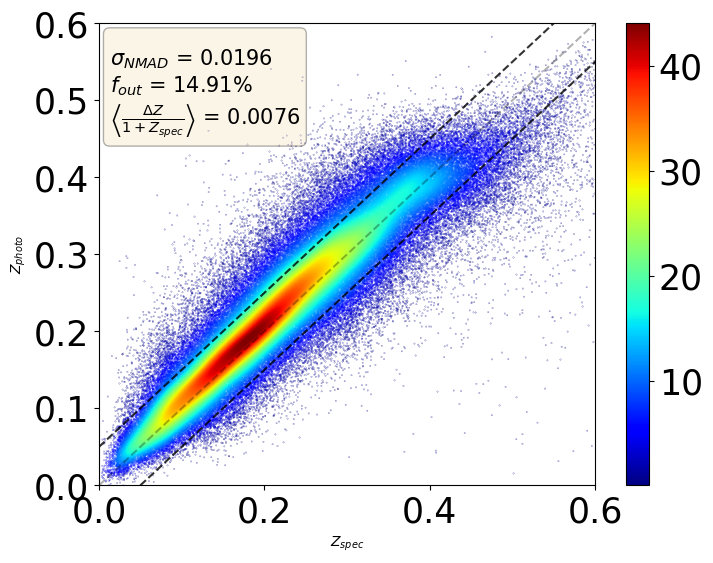

In [16]:
error = 0.05
bias, sigma_nmad, f_out = metrics(Y_test, Y_predtest, error)

fig = pl.figure(figsize=(8,6), rasterized=True)

pl.scatter(x, y, c=z, s=0.1, cmap='jet', marker='.')
pl.ylabel(r'$Z_{photo}$')
pl.xlabel(r'$Z_{spec}$')
pl.colorbar()
pl.plot(np.linspace(0,2,5), np.linspace(0,2,5), '--k', alpha=0.3)
pl.plot(np.linspace(0,2,5)+error, np.linspace(0,2,5), '--k', alpha=0.8)
pl.plot(np.linspace(0,2,5), np.linspace(0,2,5)+error, '--k', alpha=0.8)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
text_box = '\n'+r'$\sigma_{NMAD}$ = '+f'{sigma_nmad:.4f}\n'+r'$f_{out}$ = '+f'{f_out:.2f}%\n'+r'$\left<\frac{\Delta Z}{1+ Z_{spec}}\right>$ = 'f'{np.average(bias):.4f}'
pl.text(0.013, 0.6, text_box, fontsize=15, verticalalignment='top', bbox=props)
pl.xlim(0,0.6)
pl.ylim(0,0.6)
#pl.savefig('./paper_figs/fig3.5_PhotoZ.png', bbox_inches='tight')
#pl.savefig('./paper_figs/fig3.5_PhotoZ.pdf', bbox_inches='tight')
pl.show()

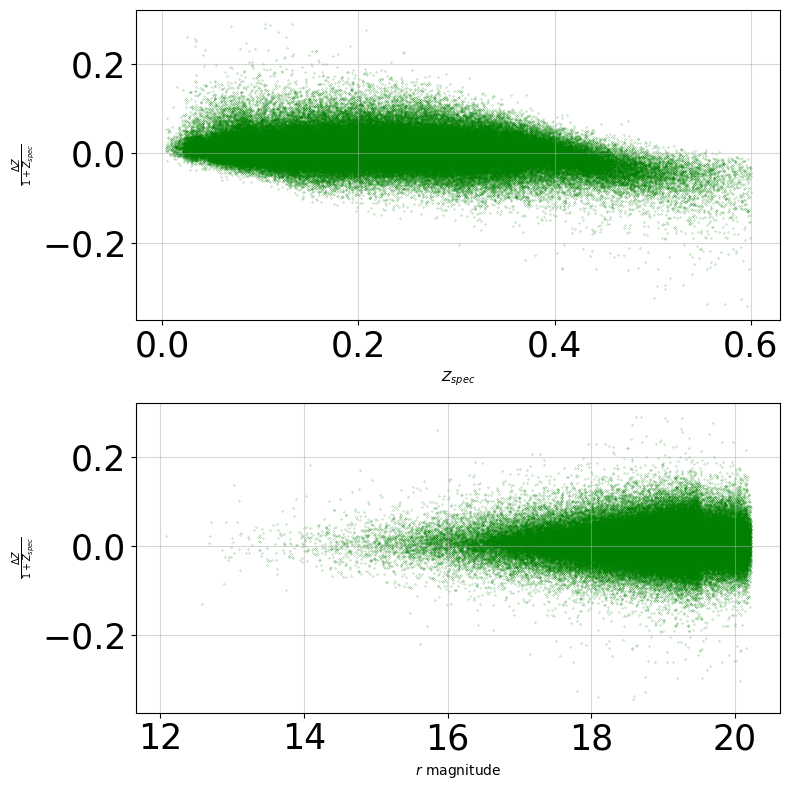

In [17]:
error = 0.05
bias, sigma_nmad, f_out = metrics(Y_test, Y_predtest, error)

fig, (ax1, ax2) = pl.subplots(2, gridspec_kw={'height_ratios': [1, 1]}, figsize=(8,8))

pl.sca(ax1)
pl.scatter(Y_test, bias, s=0.1, marker='.', color='green')
pl.ylabel(r'$\frac{\Delta Z}{1+ Z_{spec}}$')
pl.xlabel(r'$Z_{spec}$')
pl.grid(alpha=0.5)

pl.sca(ax2)
ii_z = Y_test<0.6
pl.scatter(MAG_R[LABEL=='test'][ii_z], bias, s=0.1, marker='.', color='green')
pl.ylabel(r'$\frac{\Delta Z}{1+ Z_{spec}}$')
pl.xlabel(r'$r$ magnitude')
pl.grid(alpha=0.5)

pl.tight_layout()
#pl.savefig('./paper_figs/fig3.6_PhotoZ_bias.png', bbox_inches='tight')
#pl.savefig('./paper_figs/fig3.6_PhotoZ_bias.pdf', bbox_inches='tight')
pl.show()

0.0075847297 0.0013157122


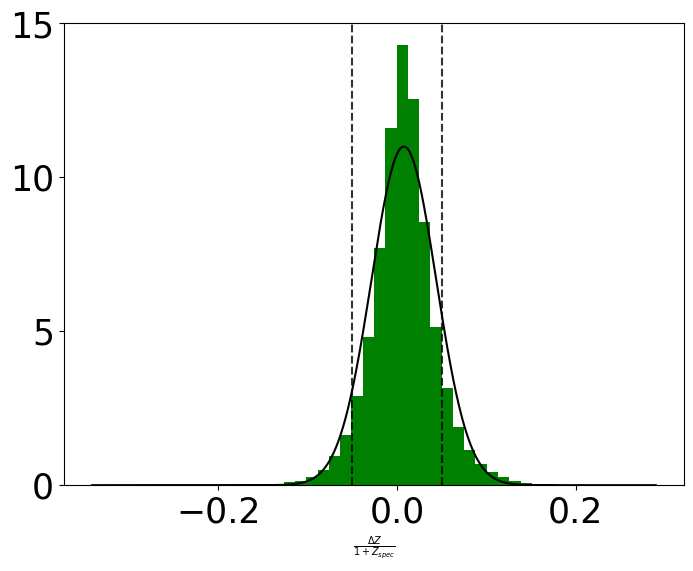

In [18]:
fig = pl.figure(figsize=(8,6), rasterized=True)

_ = pl.hist(bias, bins=50, density=True, color='green')
avg = np.mean(bias)
var = np.var(bias)

# From that, we know the shape of the fitted Gaussian.
pdf_x = np.linspace(np.min(bias),np.max(bias),1000)
pdf_y = 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(pdf_x-avg)**2/var)

pl.axvline(0.05, alpha=0.8, linestyle='--', c='k')
pl.axvline(-0.05, alpha=0.8, linestyle='--', c='k')
pl.xlabel(r'$\frac{\Delta Z}{1+ Z_{spec}}$')
pl.plot(pdf_x,pdf_y,'k-')

print(avg, var)
#pl.xlim(-0.1,0.1)

#pl.savefig('./paper_figs/fig3.7_PhotoZ_biasfit.png', bbox_inches='tight')
#pl.savefig('./paper_figs/fig3.7_PhotoZ_biasfit.pdf', bbox_inches='tight')
pl.show()